# Emulating with PcaEmulator

## Plotting boilerplate

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.8,
    rc={'lines.linewidth': 1.6, 'lines.markersize': 2},
    font='serif',
)

from mpl_toolkits import mplot3d

## Emulating a 1-dimensional function

In [4]:
import numpy as np

The emulator is able to handle any dimension of function, so we'll start with 1D. The function I'm going to emulate is
$$f(x) = x^p$$
where $p$ is the parameter we're emulating over. I'm going to let $p \in [1, 2]$, so our function varies from the line $y=x$ to the quadratic $y = x^2$.

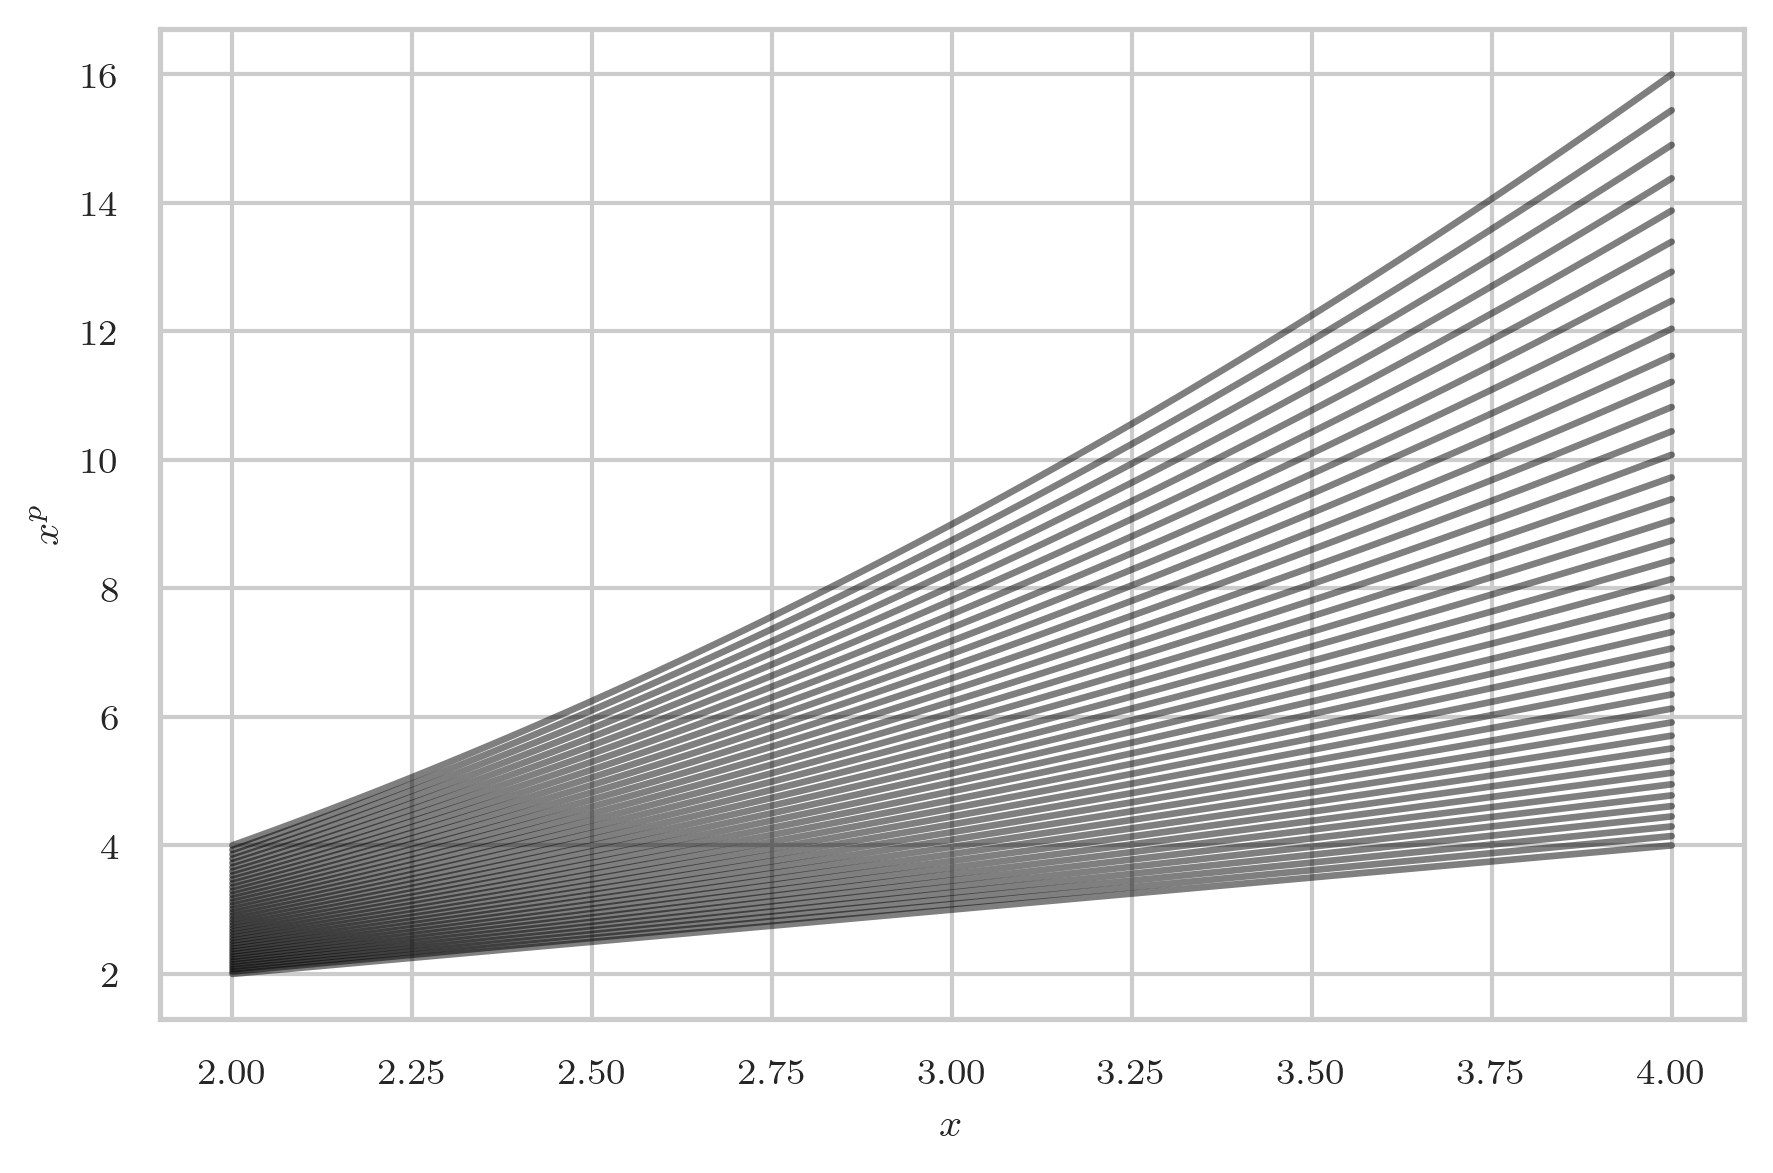

In [6]:
params_1d_training = np.linspace(1, 2, 40)
                        
xs_1d = np.linspace(2, 4, 100)

ys_1d = xs_1d[:, None]**(params_1d_training[None, :])
plt.plot(xs_1d, ys_1d, color='black', alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$x^p$')
pass

In [7]:
import ostrich.emulate
import ostrich.interpolate
import sklearn.gaussian_process.kernels

I'm going to use a GP emulator with a Matern kernel, which works pretty well in most cases. The emulator code `ostrich` has a "wrapper" for the Gaussian process interpolator, `ostrich.interpolate.GaussianProcessInterpolator`, which standardizes the kind of inputs the interpolator expects, so that is what I provide to the emulator `ostrich.emulate.PcaEmulator`.

In [8]:
emulator = ostrich.emulate.PcaEmulator.create_from_data(
    params_1d_training,
    ys_1d,
    ostrich.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': sklearn.gaussian_process.kernels.Matern()},
    num_components=10,
)

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


As far as I can tell the warnings above can be ignored

Now, to test the emulator, I'm going to randomly sample the parameter space $[1, 2]$ using `numpy.random` with 100 random $p$ values. Then I'll create the true values of the function $x^p$ and plot these, but also plot the emulator evaluated at these $p$s.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


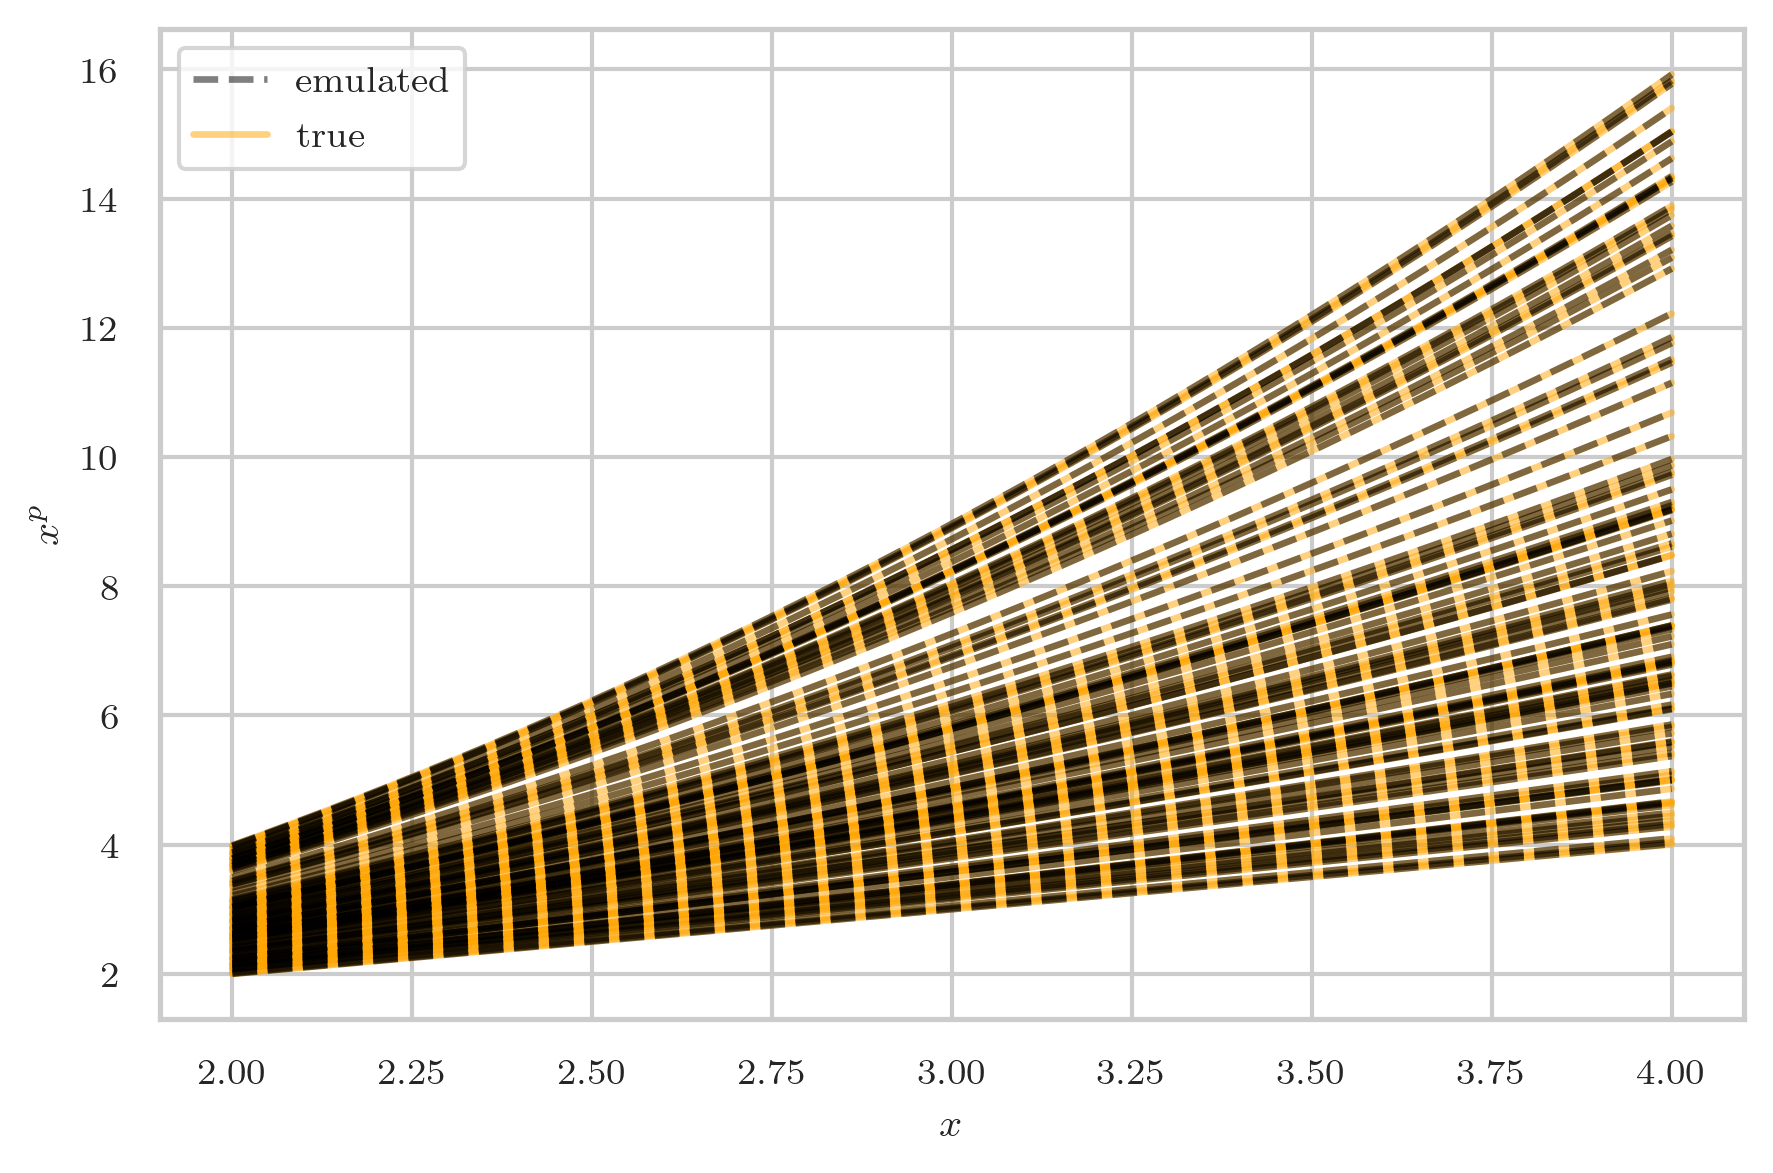

In [9]:
params_1d = np.random.rand(100) + 1
ys_true = xs_1d[:, None]**(params_1d[None, :])

plt.plot(xs_1d, ys_true, color='orange', alpha=0.5, label='true')
plt.plot(xs_1d, emulator(params_1d), color='black', linestyle='--', alpha=0.5, label='emulated')
plt.xlabel(r'$x$')
plt.ylabel(r'$x^p$')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')
pass

The emulated function (black) and the true function (orange) are indistinguishable to the eye, which is a good sign. But to quantify the errors from emulation I prefer to work with the quantity
$$\epsilon = \frac{\mathrm{emulated} - \mathrm{true}}{\mathrm{true}}$$
A value of $\epsilon$ that is $0.03$ or $-0.03$ means that the emulator was 3% over or under the true value respectively, which makes $\epsilon$ a very nice quantity to work with. To start with I'll plot $\epsilon$ curves as a function of $x$, multiplying by 100 to convert to percent:

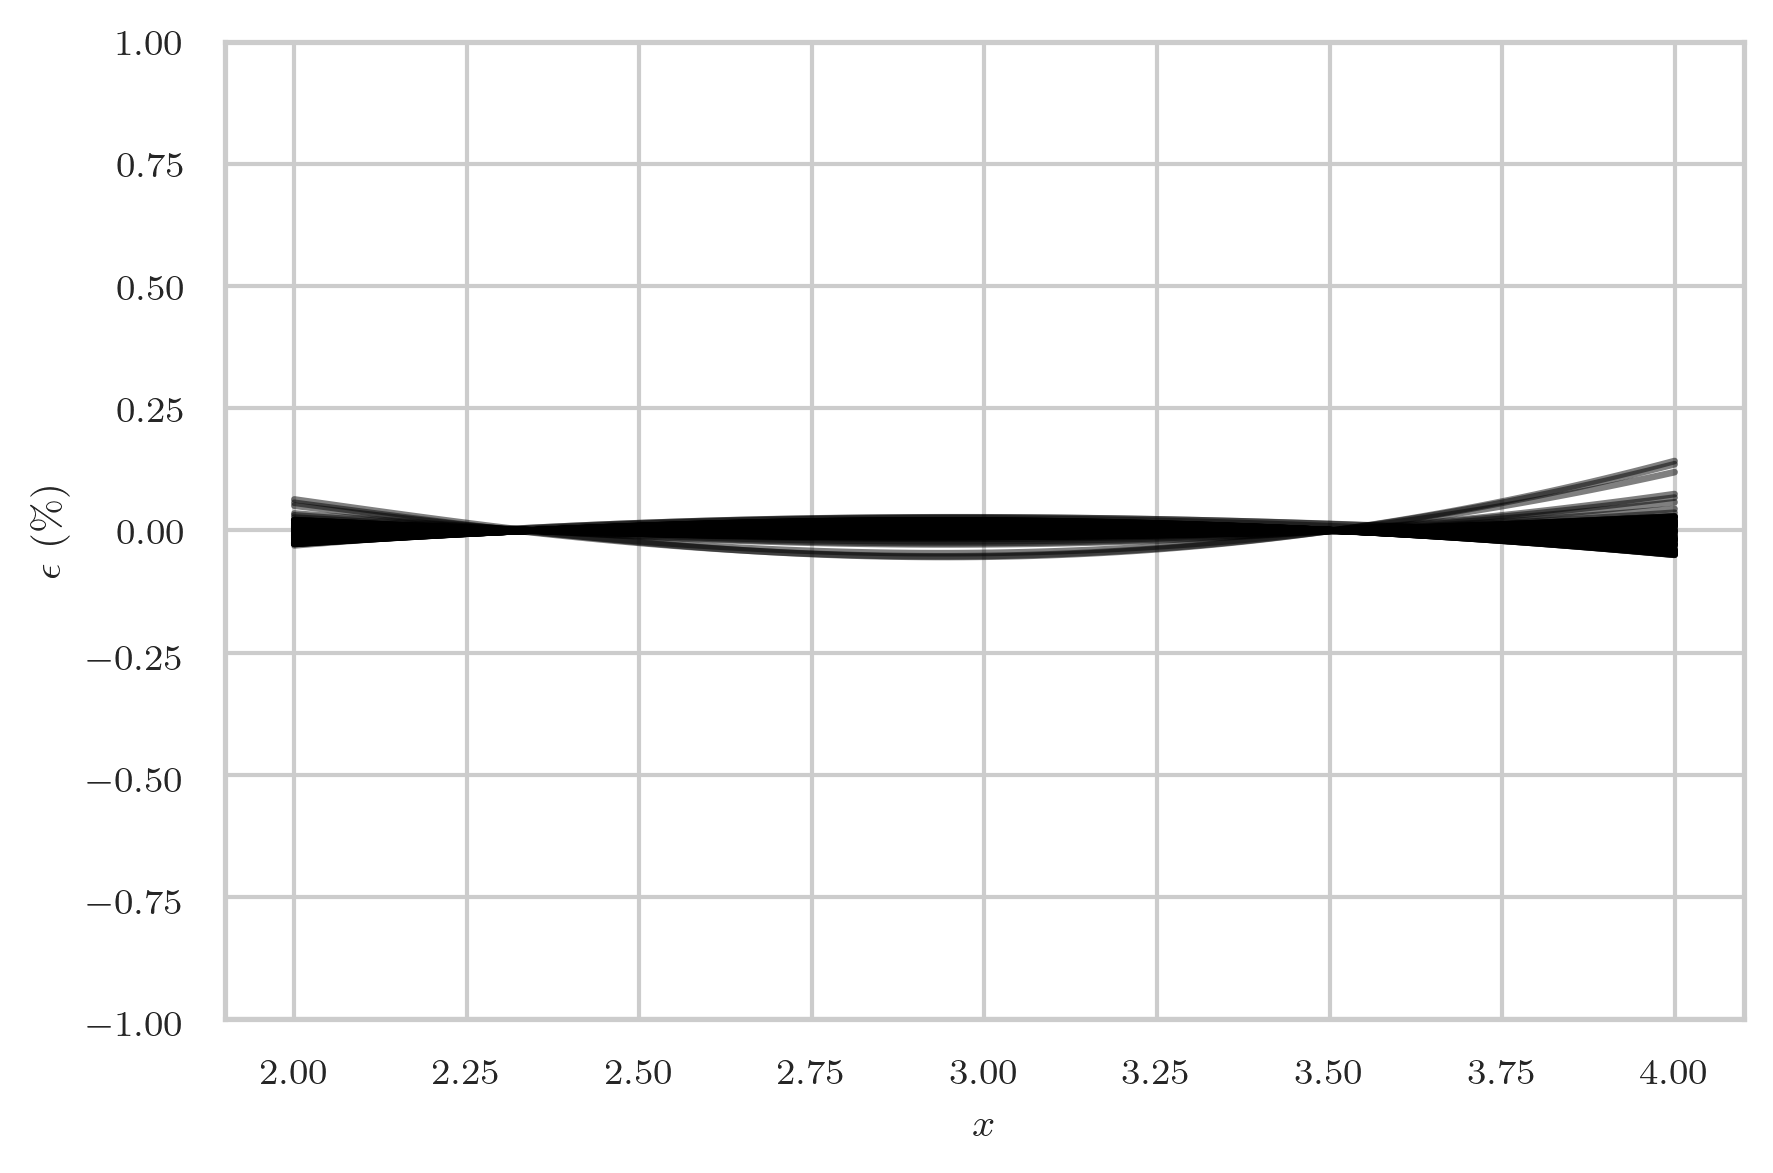

In [11]:
errs_1d = (emulator(params_1d) - ys_true)/ys_true
plt.plot(xs_1d, 100*errs_1d, color='black', alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\epsilon$ (\%)')
plt.ylim((-1, 1))
pass

So everything is well under 1%. That means all of the errors are less than 1%, which is pretty great. However this visualization isn't always good at examining the error of emulators that perform worse, so let's look at a couple of other plots.

Next, let's take the mean absolute value error as a function of $x$. This means we take the absolute value of $\epsilon$, then take the mean of that. The mean of just $\epsilon$ is almost always extremely close to $0$, which is only because the errors tend to be equally likely to be under the true values as they are to be over the true values, so it doesn't really help quantify the accuracy. The absolute value means we're looking at on average what the deviation is from the true value of the function:

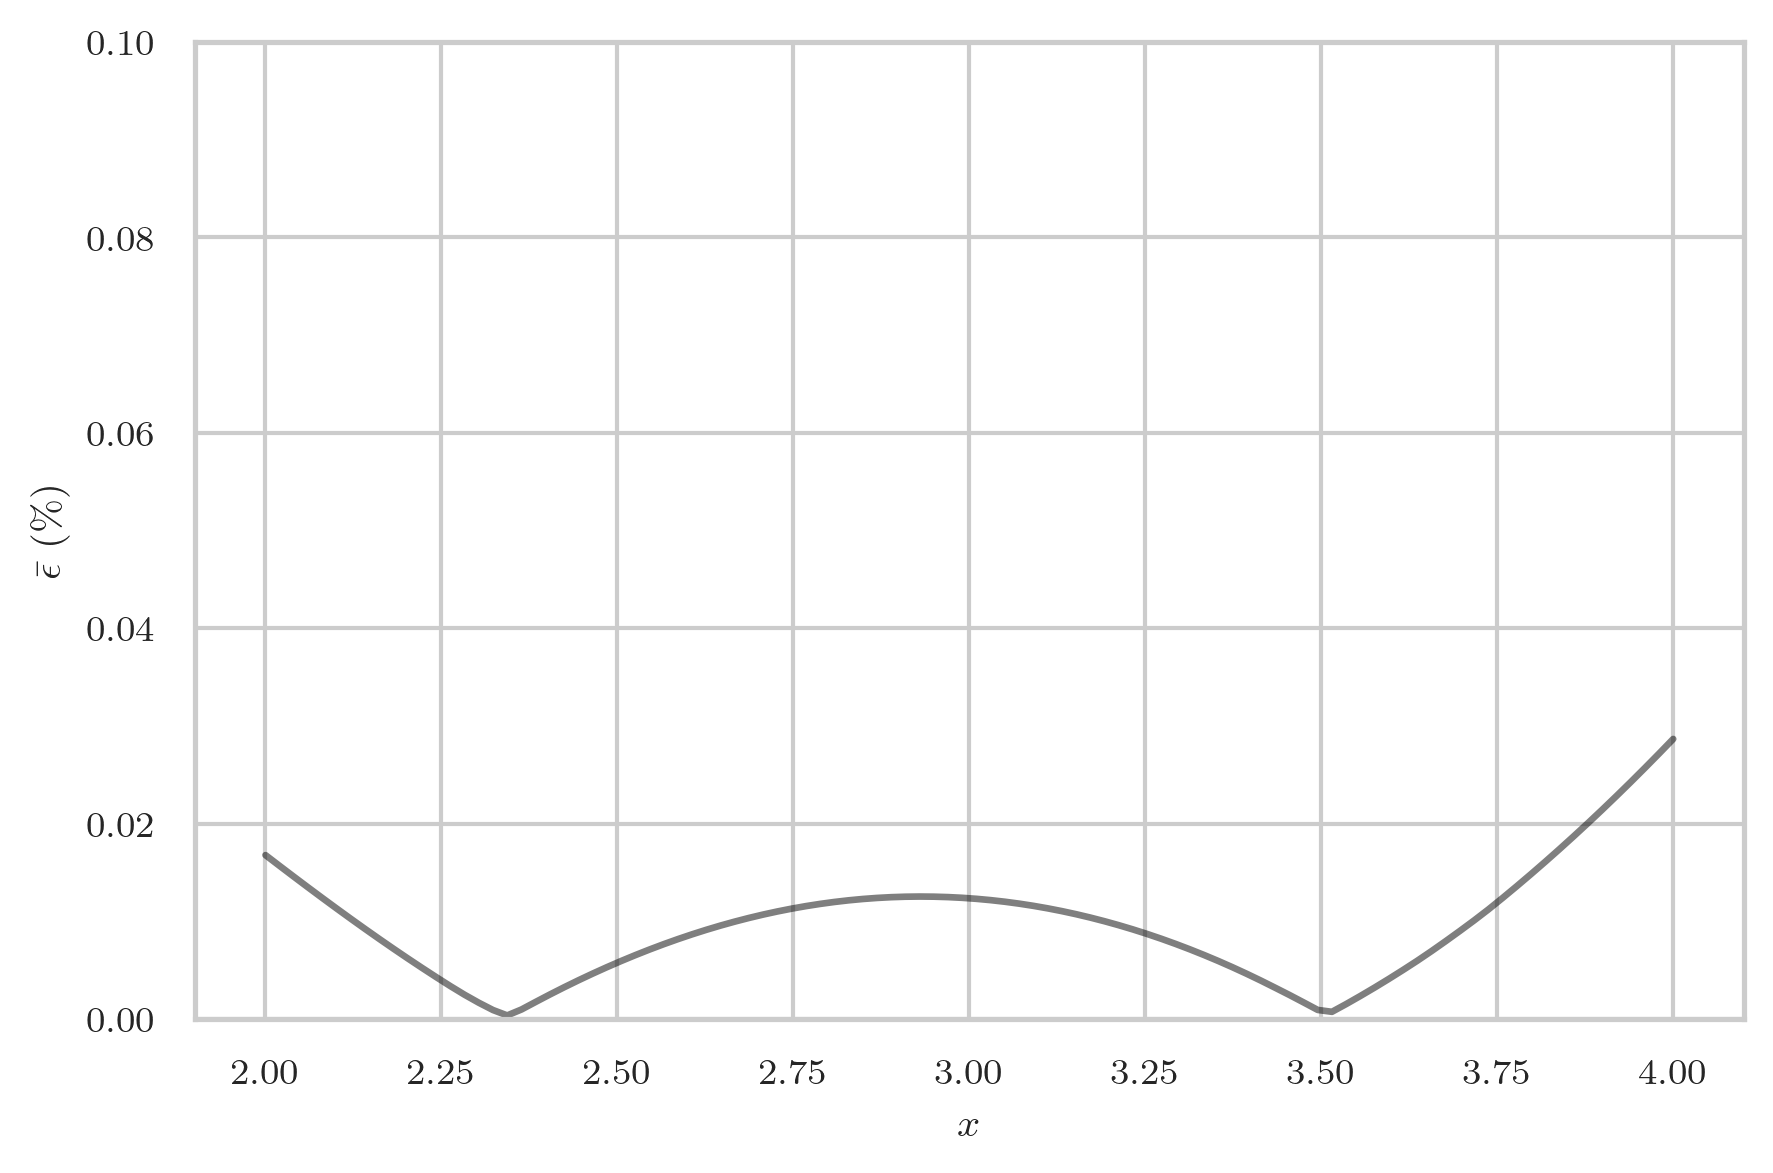

In [12]:
plt.plot(xs_1d, 100*np.abs(errs_1d).mean(axis=1), color='black', alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\bar \epsilon$ (\%)')
plt.ylim((0, 0.1))
pass

So, on average the error is less than 0.1% from the true value, and it also tends to get worse for certain values of $x$, but very low at particular $x$ values near 2.3 and 3.5.

Again while the plot above is sometimes useful, it isn't always the best way to understand emulator performance. The best way to actually quantify the emulator's accuracy is by looking at the distribution of errors in their entirety, so we can see what the bulk of errors are, as well as what outliers exist. It is most convenient to do this in log-space, that is, not to look at $\epsilon$, but $\log_{10}(|\epsilon|)$. The absolute value is needed so the negative values don't explode the log, and we take the log base 10 to conveniently put the $10\%$ error level at -1, the $1\%$ level at -2, the $0.1\% level at -3, etc. Then we can look at the histogram of these to see what the distribution is:

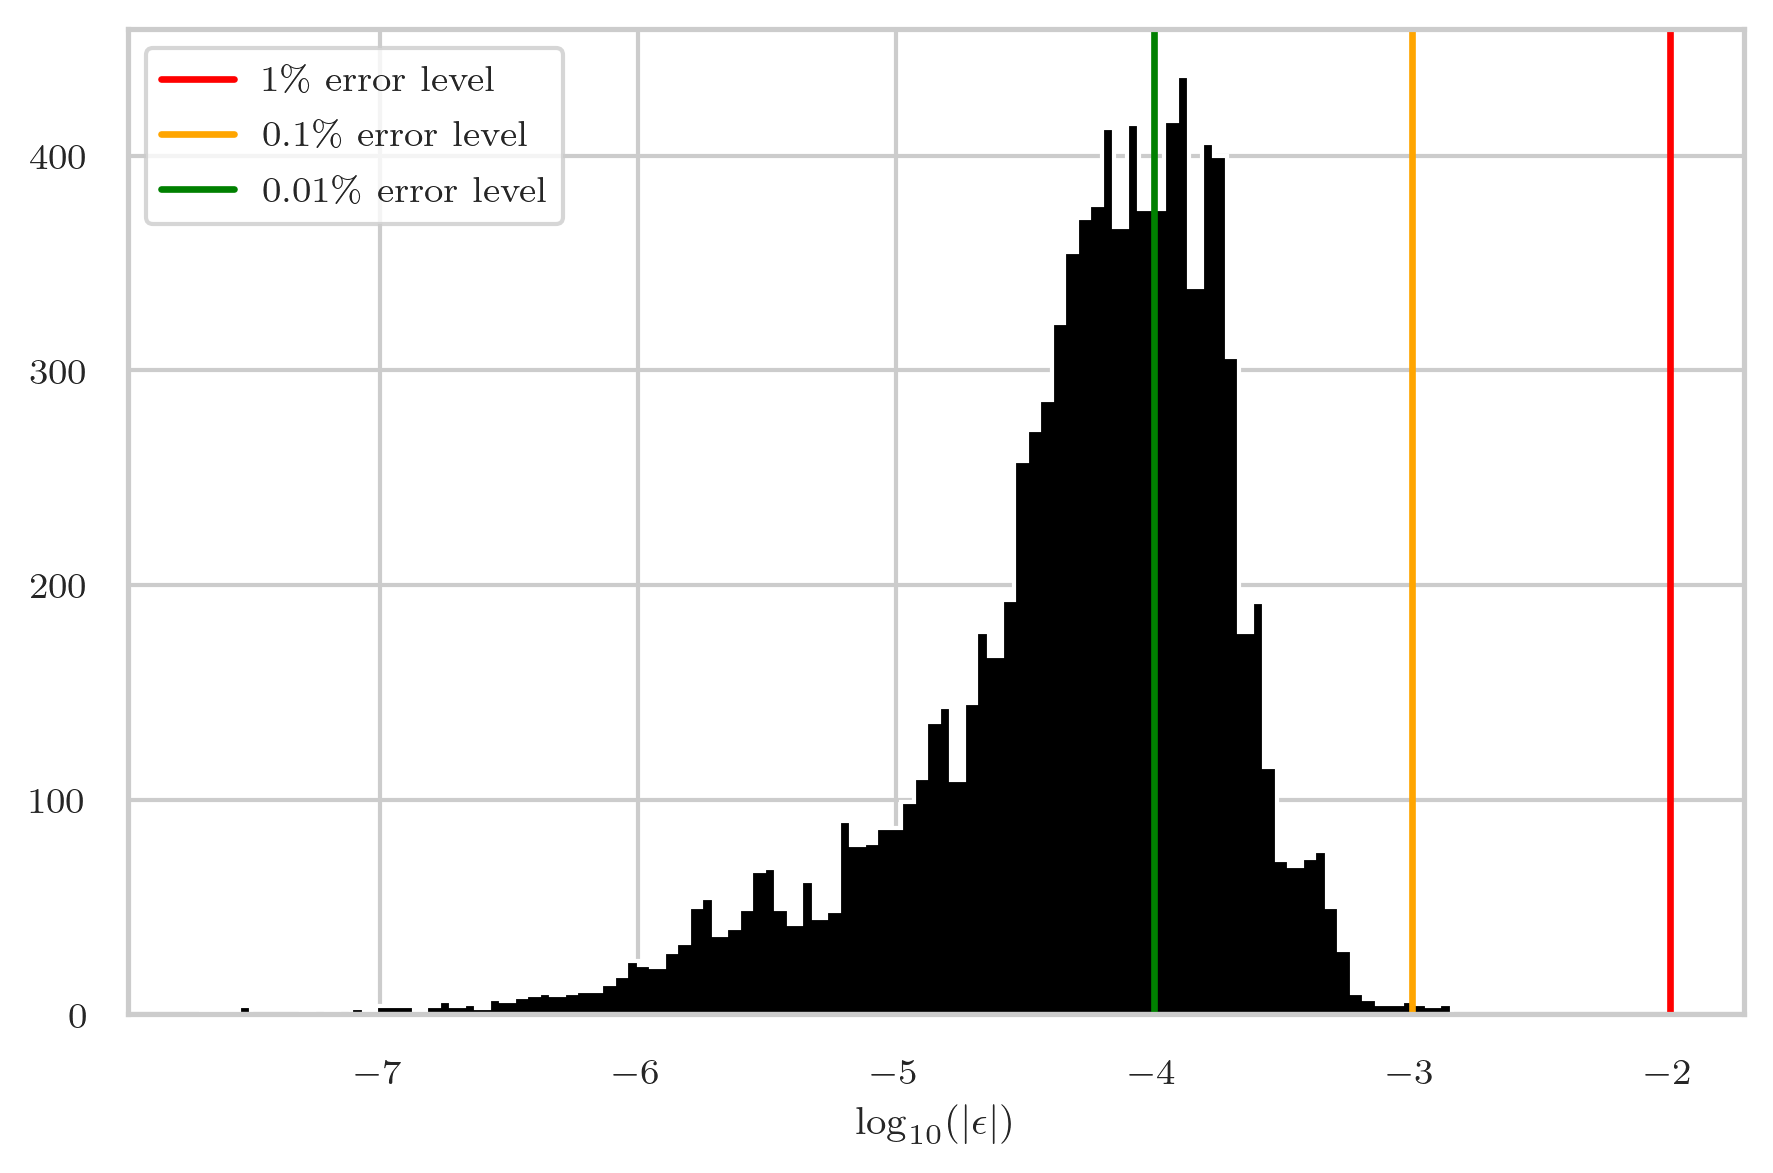

In [14]:
plt.hist(np.log10(np.abs(errs_1d.flatten())), color='black', histtype='stepfilled', bins=100)
plt.axvline(-2, label='1\% error level', color='red')
plt.axvline(-3, label='0.1\% error level', color='orange')
plt.axvline(-4, label='0.01\% error level', color='green')
plt.legend(loc='best')
plt.xlabel(r'$\log_{10}(|\epsilon|)$')
pass

Here it's very obvious how well the emulator is doing. The bulk of the errors are between $0.001\%$ and $0.01\%$, which is very good, with a few trickling over $0.1\%$, which is still quite good. There are also outliers which are much, much smaller.

## Emulating a 2-d function

Now let's go to a 2-D function, and also increase the number of parameters to 2. Here, I'll be using the function
$$f(x, y) = (xy)^b + a$$

where $a \in [0, 1]$ and $b \in [1, 2]$ are the two parameters being emulated. To sample this parameters I''m going to use a 2D latin hypercube, which is probably overkill but works well enough. I use my own Latin Hypercube program `supercubos` to generate this:

In [15]:
import supercubos

In [16]:
param_2d_mins = np.array([0, 1])
param_2d_maxes = np.array([1, 2])
n_2d = 80
lh_2d = supercubos.LatinSampler().get_lh_sample(param_2d_mins, param_2d_maxes, n_2d)
as_ = lh_2d[:, 0][None, None, :]
bs = lh_2d[:, 1][None, None, :]
 
xs_2d = np.linspace(-1, 1, 100)
ys_2d = np.linspace(-1, 1, 101)

zs_2d = ((xs_2d[:, None, None]*ys_2d[None, :, None])**2)**(bs) + as_

Now I'll plot these with a 3D plot so we can see what they look like:

In [17]:
def plot_3d(xs, ys, zs, ax, color='black', alpha=0.2):
    X, Y = np.meshgrid(ys, xs)
    ax.plot_wireframe(
        X,
        Y,
        zs,
        color=color,
        alpha=alpha,
        rcount=20,
        ccount=20,
    )

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


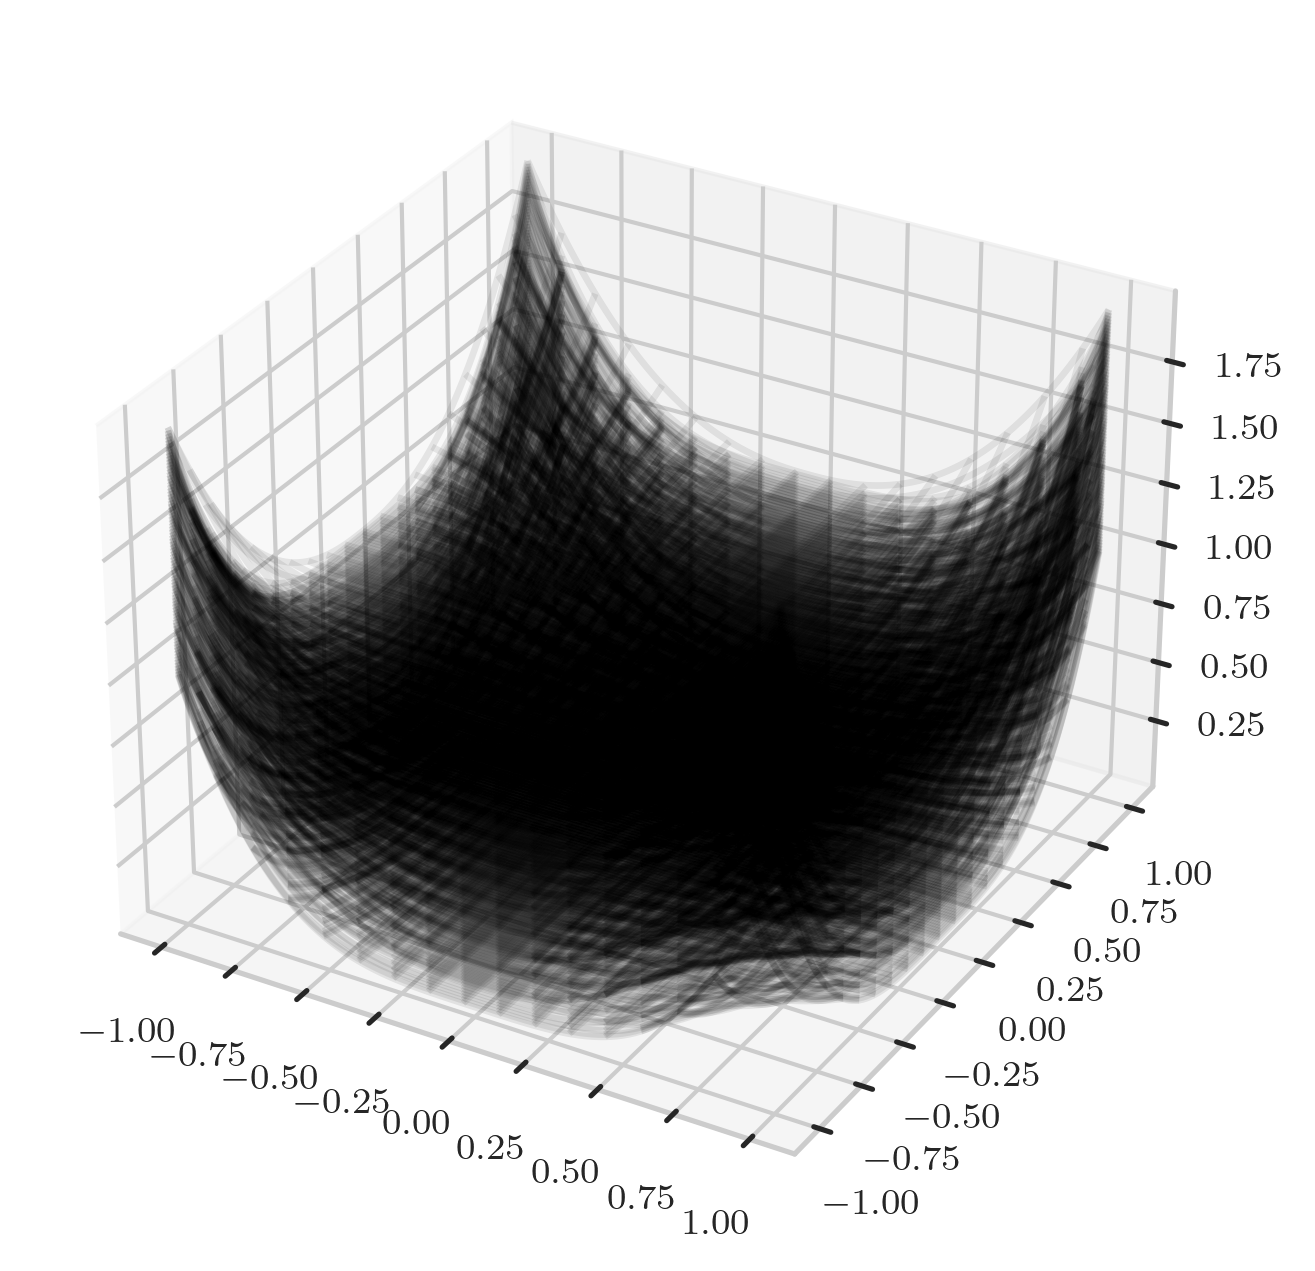

In [18]:
fig = plt.figure()
ax = mplot3d.Axes3D(fig)
for i in range(n_2d):
    plot_3d(xs_2d, ys_2d, zs_2d[:, :, i], ax, alpha=0.08, color='black')

In [19]:
lh_2d[25, :]

array([0.86875, 1.40625])

You can kind of get the idea, but the plot is pretty crowded with 80 combinations of parameters, so let's just chose the one where $a = 0.86875$ and $b=1.40625$:

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


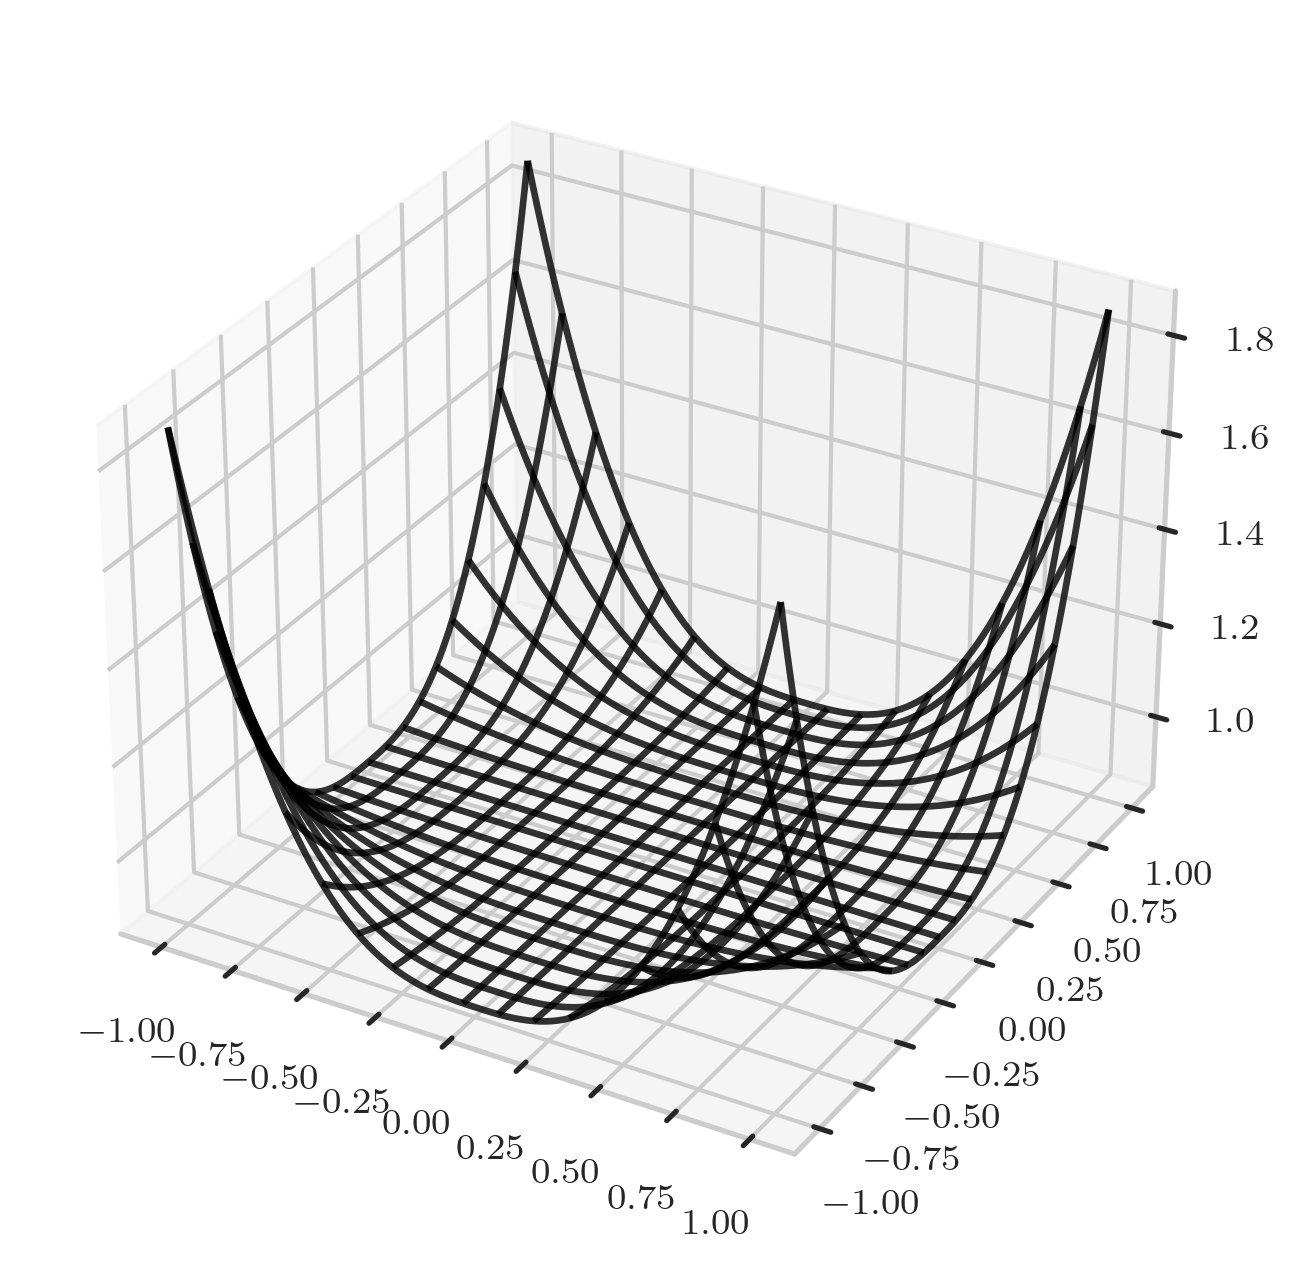

In [20]:
fig = plt.figure()
ax = mplot3d.Axes3D(fig)
plot_3d(xs_2d, ys_2d, zs_2d[:, :, 25], ax, alpha=0.8, color='black')

In [23]:
zs_2d.reshape(-1, 80).shape

(10100, 80)

So this function has some extreme behavior as far as steep curvature, anyway. Let's see how the emulator performs. Note that for higher dimensional functions, we need to reshape the function data, currently in numpy array shape `(100, 101, 80)` (or number of xs by number of ys by number of parameter combos), to be `(100\*101, 80)`, putting the xs and ys together.

In [24]:
emulator_2d = ostrich.emulate.PcaEmulator.create_from_data(
    lh_2d,
    zs_2d.reshape(-1, n_2d),
    ostrich.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': sklearn.gaussian_process.kernels.Matern()},
    num_components=10,
)

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


Now let's do the same type of test as before, only this time I'm going to generate 1000 test samples randomly over the 2D parameter space. Generally you want a test sample as large as possible to get a good representative sample of errors. 

In [25]:
test_params_2d = supercubos.LatinSampler().get_rand_sample(param_2d_mins, param_2d_maxes, 1000)
as_ = test_params_2d[:, 0][None, None, :]
bs = test_params_2d[:, 1][None, None, :]
 
true_zs_2d = ((xs_2d[:, None, None]*ys_2d[None, :, None])**2)**(bs) + as_

emulated_zs_2d = emulator_2d(test_params_2d).reshape(100, 101, -1)

In [26]:
emulated_zs_2d.shape

(100, 101, 1000)

Note that we reshaped the emulator output to be back in `(100, 101, 1000)`.

Plotting the true values and the emulated values is an utter mess all together, so let's just stick with our one example curve:

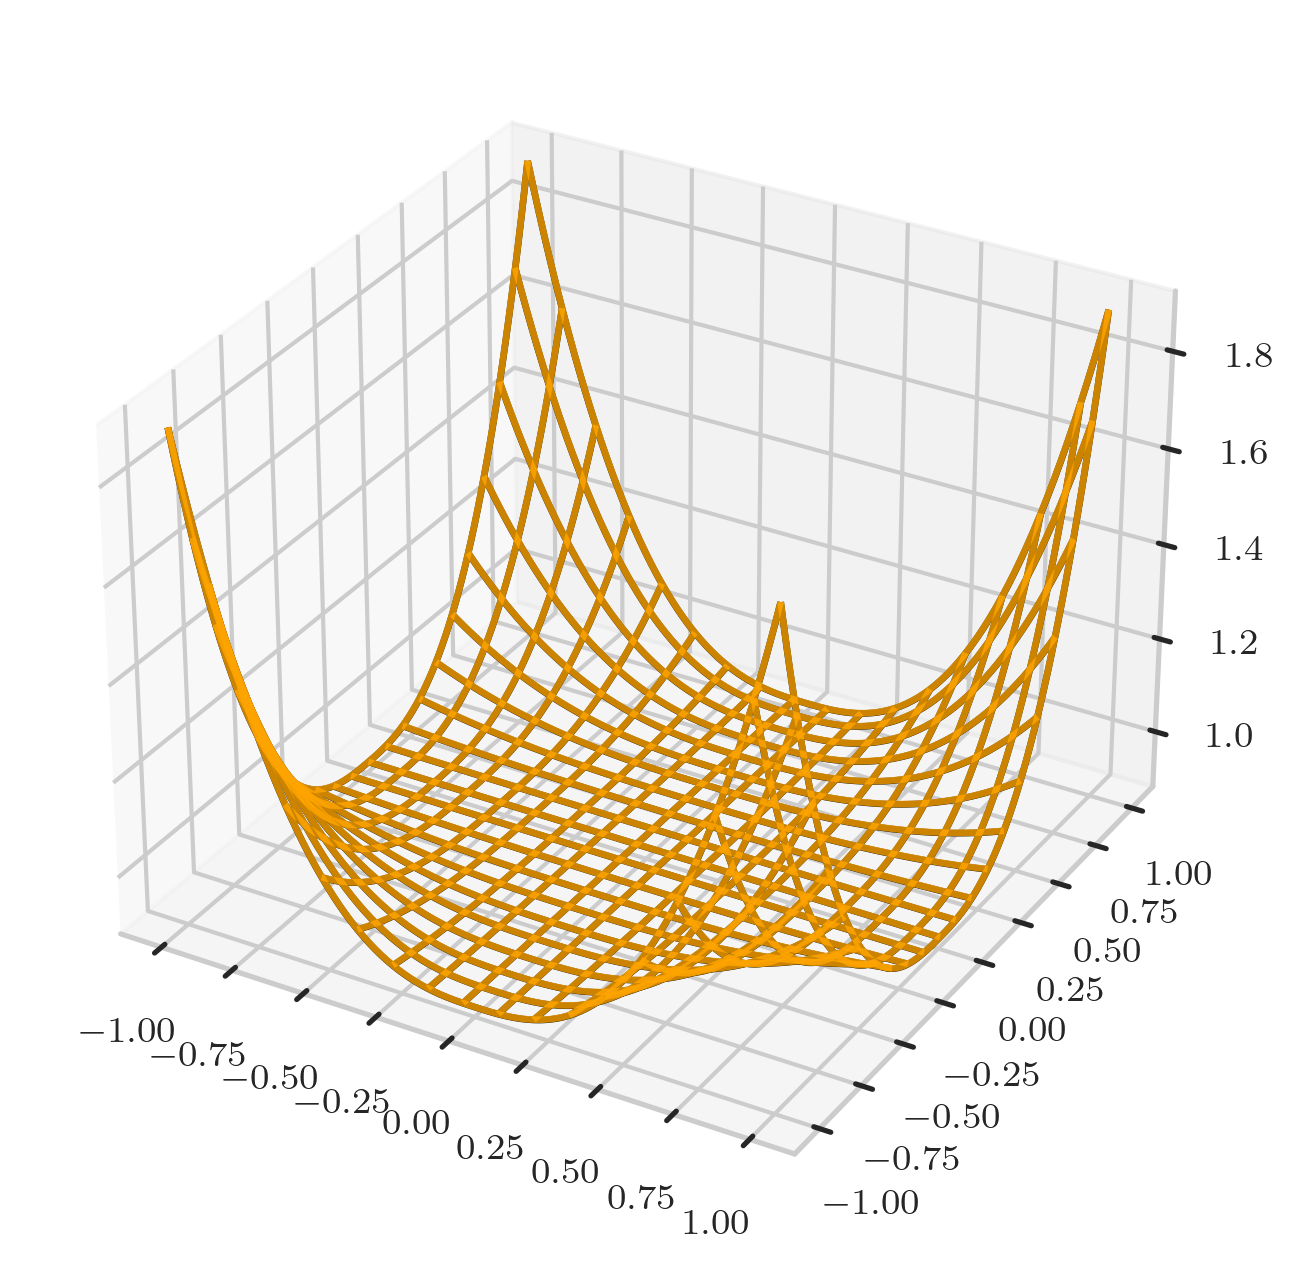

In [30]:
fig = plt.figure()
ax = mplot3d.Axes3D(fig)
plot_3d(xs_2d, ys_2d, true_zs_2d[:, :, 25], ax, alpha=1, color='black')

plot_3d(xs_2d, ys_2d, emulated_zs_2d[:, :, 25], ax, alpha=0.8, color='orange')

So this looks good, but obviously we can't come to any conclusions just by looking at this one sample. So let's again calculate the errors:

In [31]:
errs_2d = (emulated_zs_2d - true_zs_2d)/true_zs_2d

We can look at the average errors as functions of $x$ and $y$ separately:

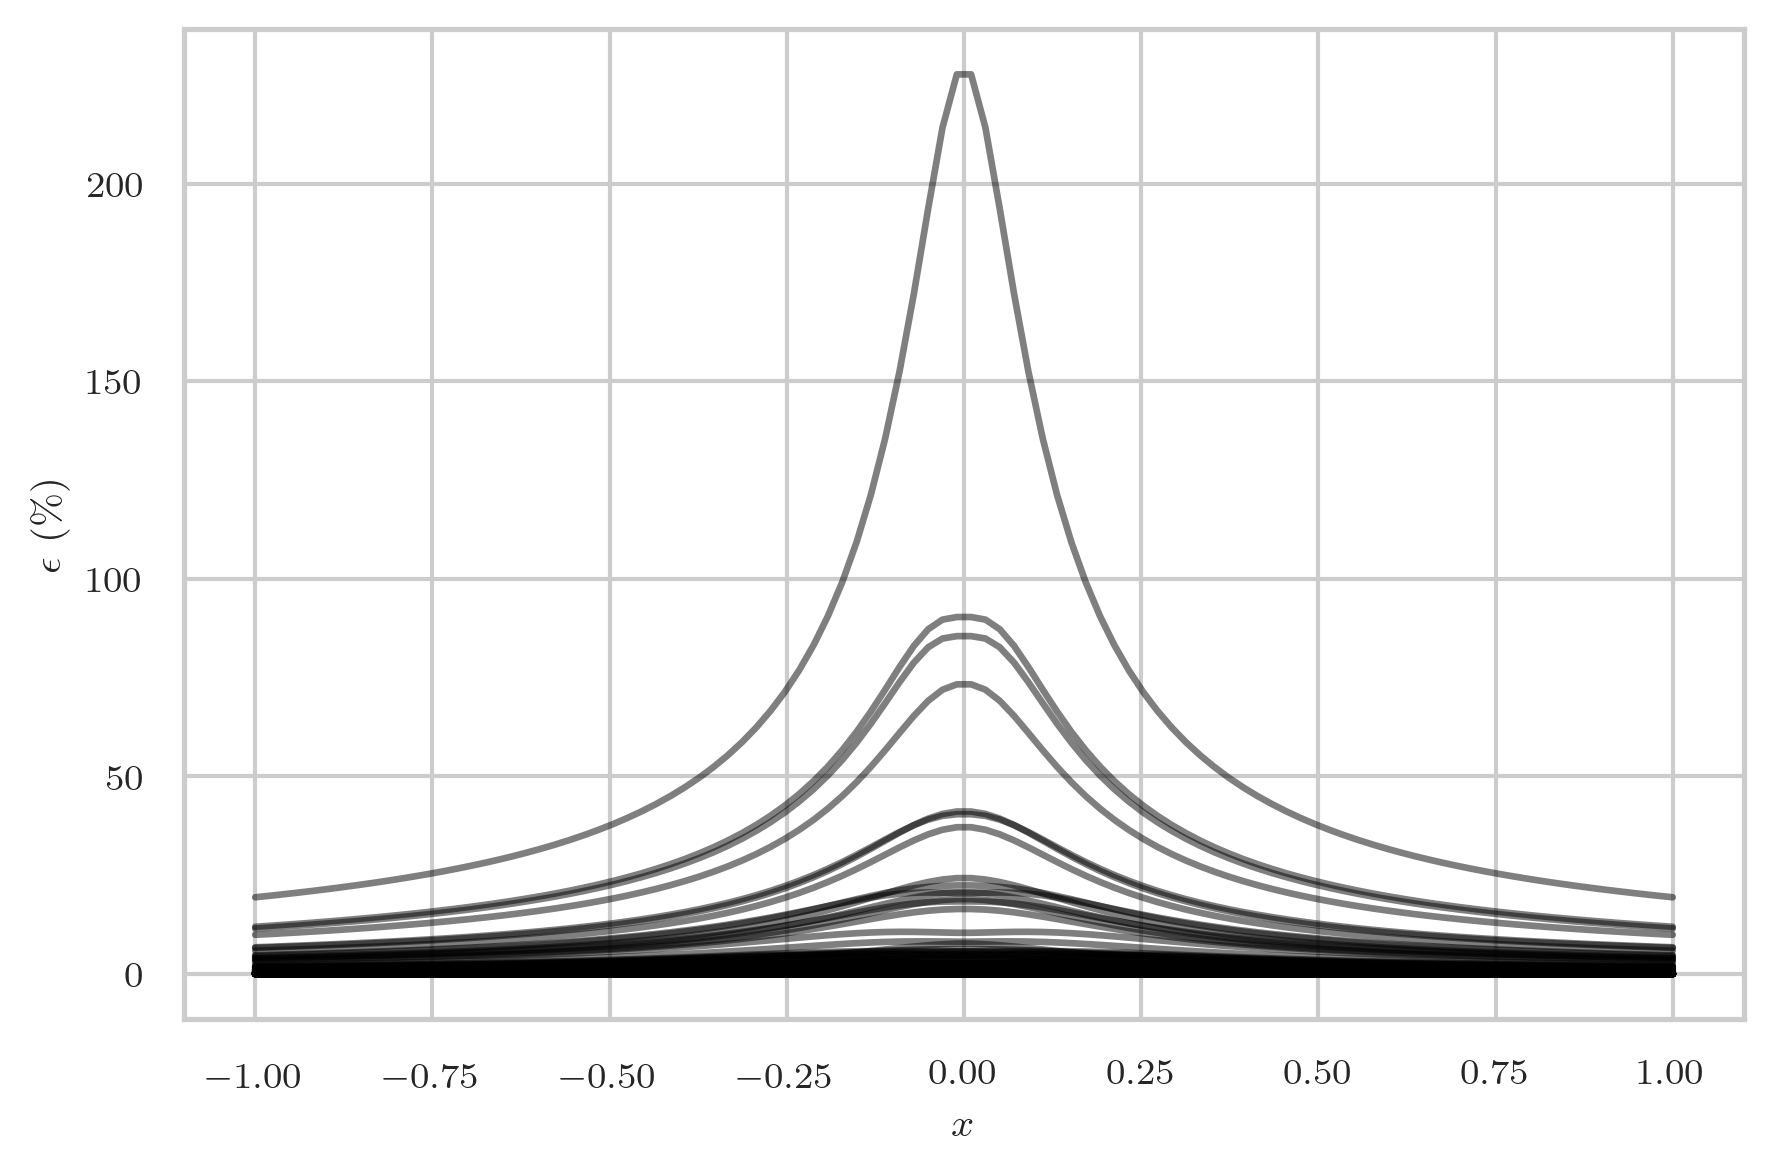

In [32]:
plt.plot(xs_2d, 100*np.abs(errs_2d).mean(axis=1), color='black', alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\epsilon$ (\%)')
pass

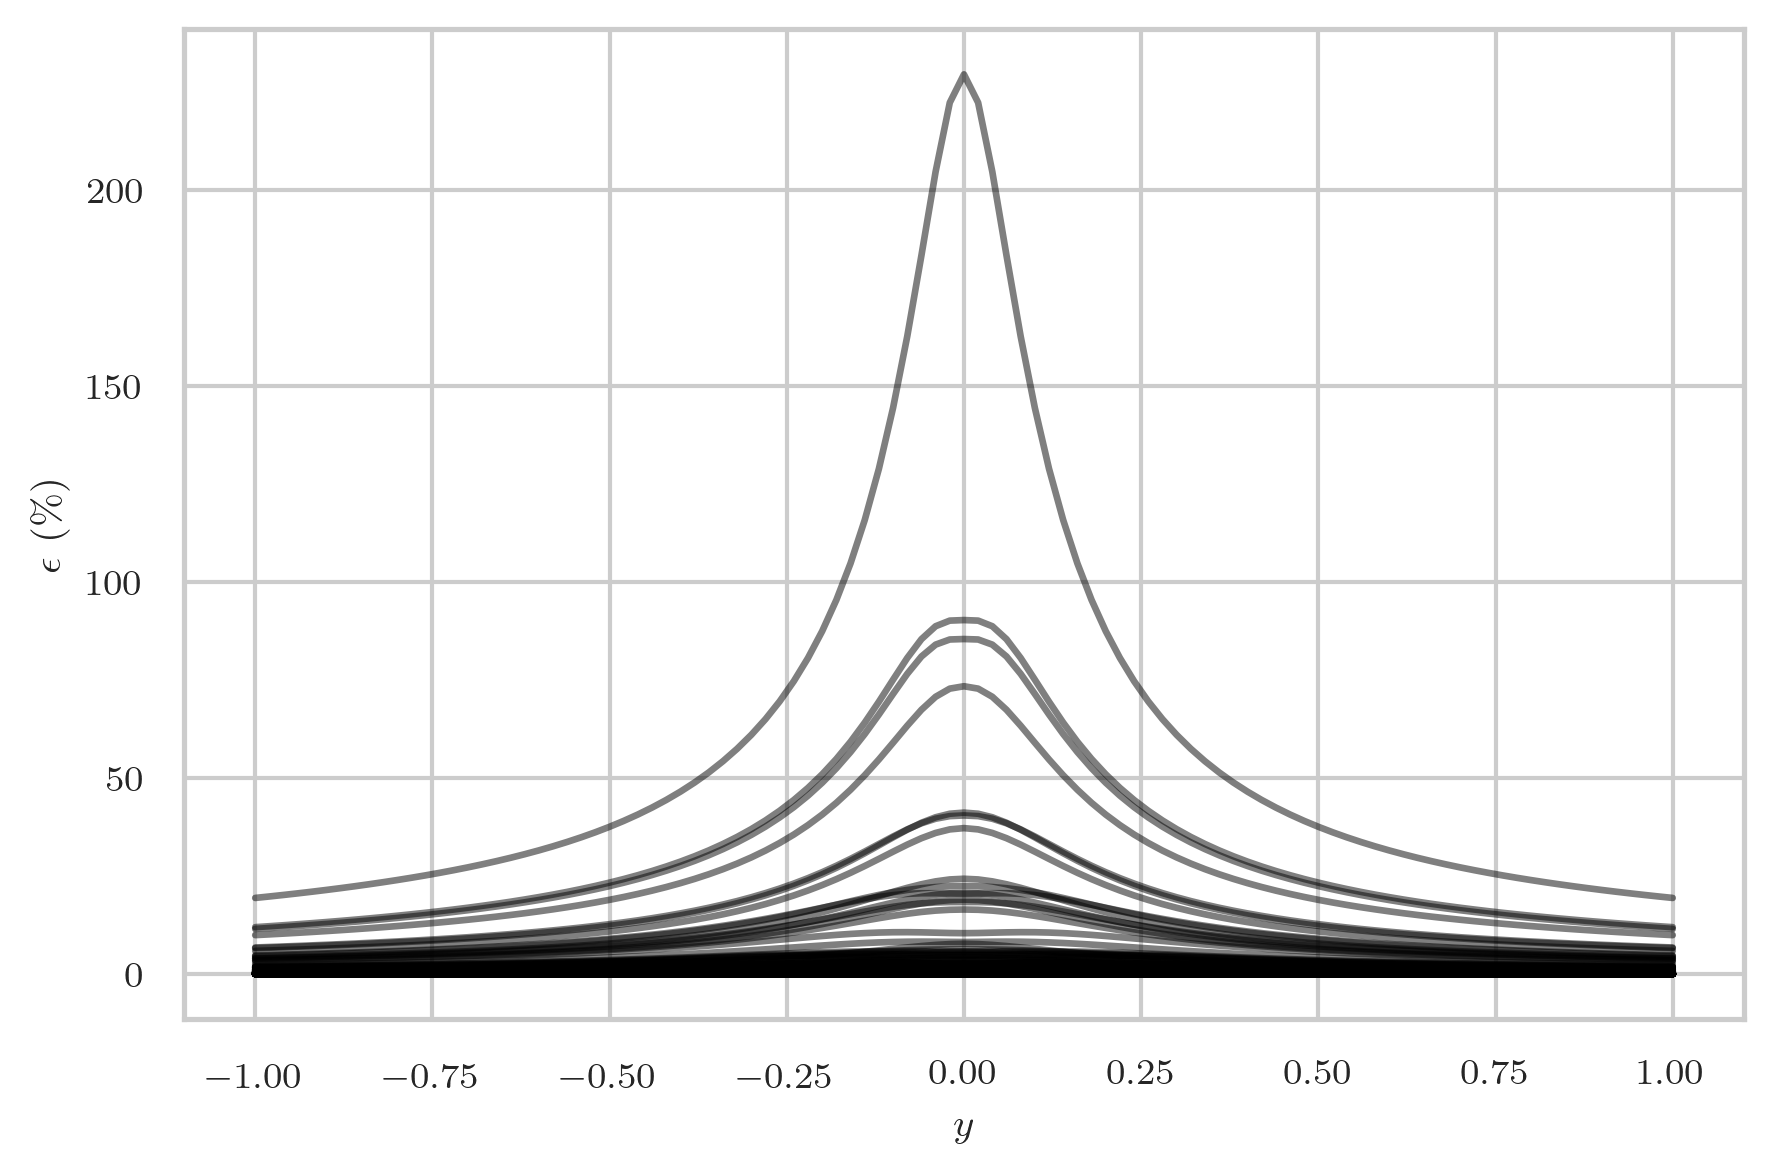

In [33]:
plt.plot(ys_2d, 100*np.abs(errs_2d).mean(axis=0), color='black', alpha=0.5)
plt.xlabel(r'$y$')
plt.ylabel(r'$\epsilon$ (\%)')
pass

Here, because our parameters are 2-dimensional, and the function is more complicated, some errors are much larger. You can also see that they are largest in the center. Here concluding anything about how well the emulator is working is hard, so we'll look at the histogram of the $\log_{10}$ absolute values again:

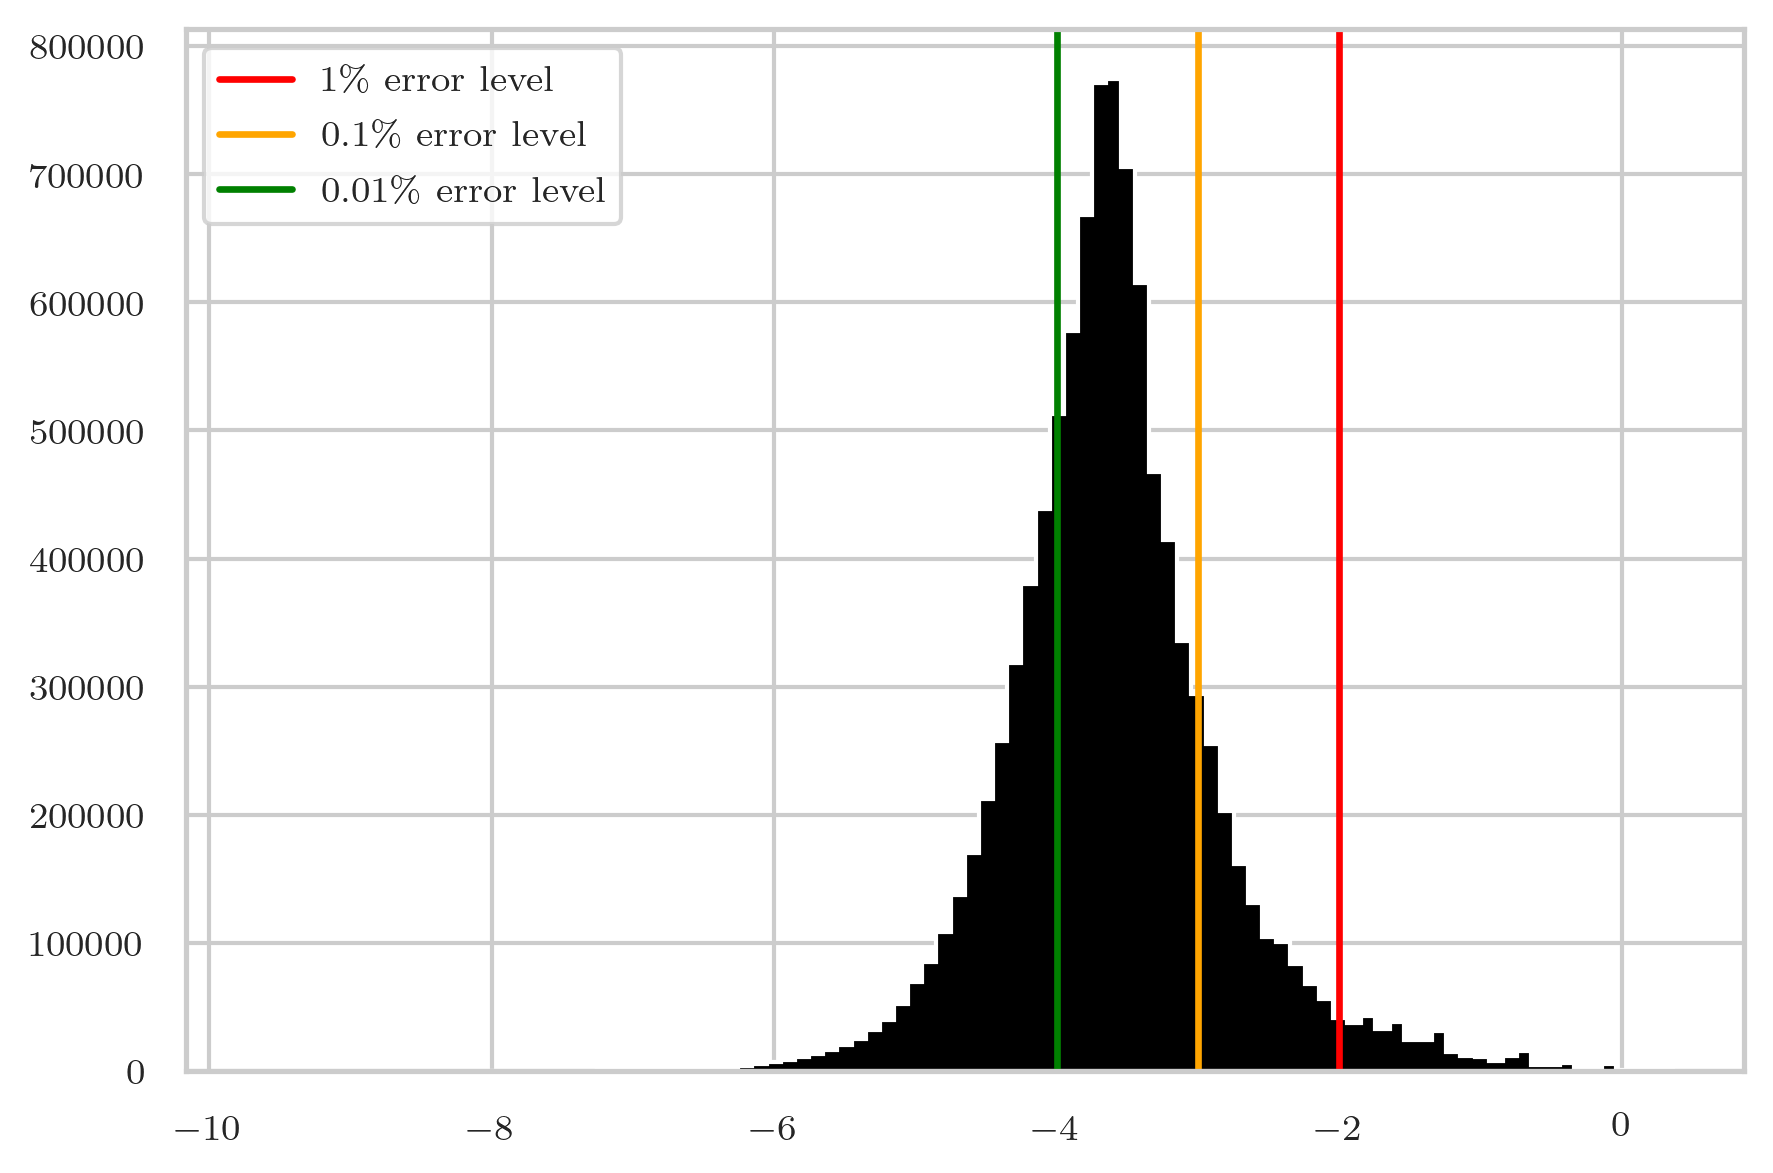

In [34]:
plt.hist(np.log10(np.abs(errs_2d.flatten())), color='black', histtype='stepfilled', bins=100)
plt.axvline(-2, label='1\% error level', color='red')
plt.axvline(-3, label='0.1\% error level', color='orange')
plt.axvline(-4, label='0.01\% error level', color='green')
plt.legend(loc='best')
pass

Here, we can see that the errors are actually mostly fine and well under $1\%$, but there is a tail of outliers that get quite large, and close to $100\%$. We saw above that this is a systematic overestimation of the middle of the function, near $x = y = 0$. So for this function we'd probably want to sample more $a$ and $b$ values with a larger latin hypercube. 


Note that this increase isn't due to an increase in the function's dimension, i.e. going from just $x$ to $x$ and $y$: We can illustrate this by going up in function dimension again, to $x$, $y$, and $z$ inputs, but only using 1 parameter again.

## Emulating a 3-dimensional function

The function I'll emulate this time is
$$f(x, y, z) = \left(\sqrt{x^2 + y^4 + z^6}\right)^p$$
where again $p \in [1, 3]$ is the one parameter we're emulating.

I'll use 400 samples this time, less than the 1000 samples I used for 2D.

In [62]:
xs_3d = ys_3d = zs_3d = np.linspace(-1, 1, 30)
n_3d = 400
params_3d_training = np.linspace(1, 3, n_3d)
function_vals_3d = np.sqrt(xs_3d[:, None, None]**2 + ys_3d[None, :, None]**4 + zs_3d[None, None, :]**6)
function_vals_3d = function_vals_3d[..., None]**(params_3d_training[None, None, None, :])

I'm not going to try to plot this 3D function as the facilities to do so in any visually useful way don't exist in Matplotlib. Instead let's just build the emulator:

In [63]:
emulator_3d = ostrich.emulate.PcaEmulator.create_from_data(
    params_3d_training,
    function_vals_3d.reshape(-1, n_3d),
    ostrich.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': sklearn.gaussian_process.kernels.Matern()},
    num_components=10,
)

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


Again I'm going to use 1000 test points:

In [64]:
n_3d_test = 1000
params_3d = np.linspace(1, 3, n_3d_test)
true_function_vals_3d = np.sqrt(xs_3d[:, None, None]**2 + ys_3d[None, :, None]**4 + zs_3d[None, None, :]**6)
true_function_vals_3d = true_function_vals_3d[..., None]**(params_3d[None, None, None, :])

Note again we had to reshape the data input into the emulator to `(30*30*30, num_samples)`, so again we'll reshape the output of the emulator to `(30, 30, 30, num_samples)`:

In [65]:
emulated_vals_3d = emulator_3d(params_3d).reshape(30, 30, 30, n_3d_test)

In [66]:
errs_3d = (emulated_vals_3d - true_function_vals_3d)/true_function_vals_3d

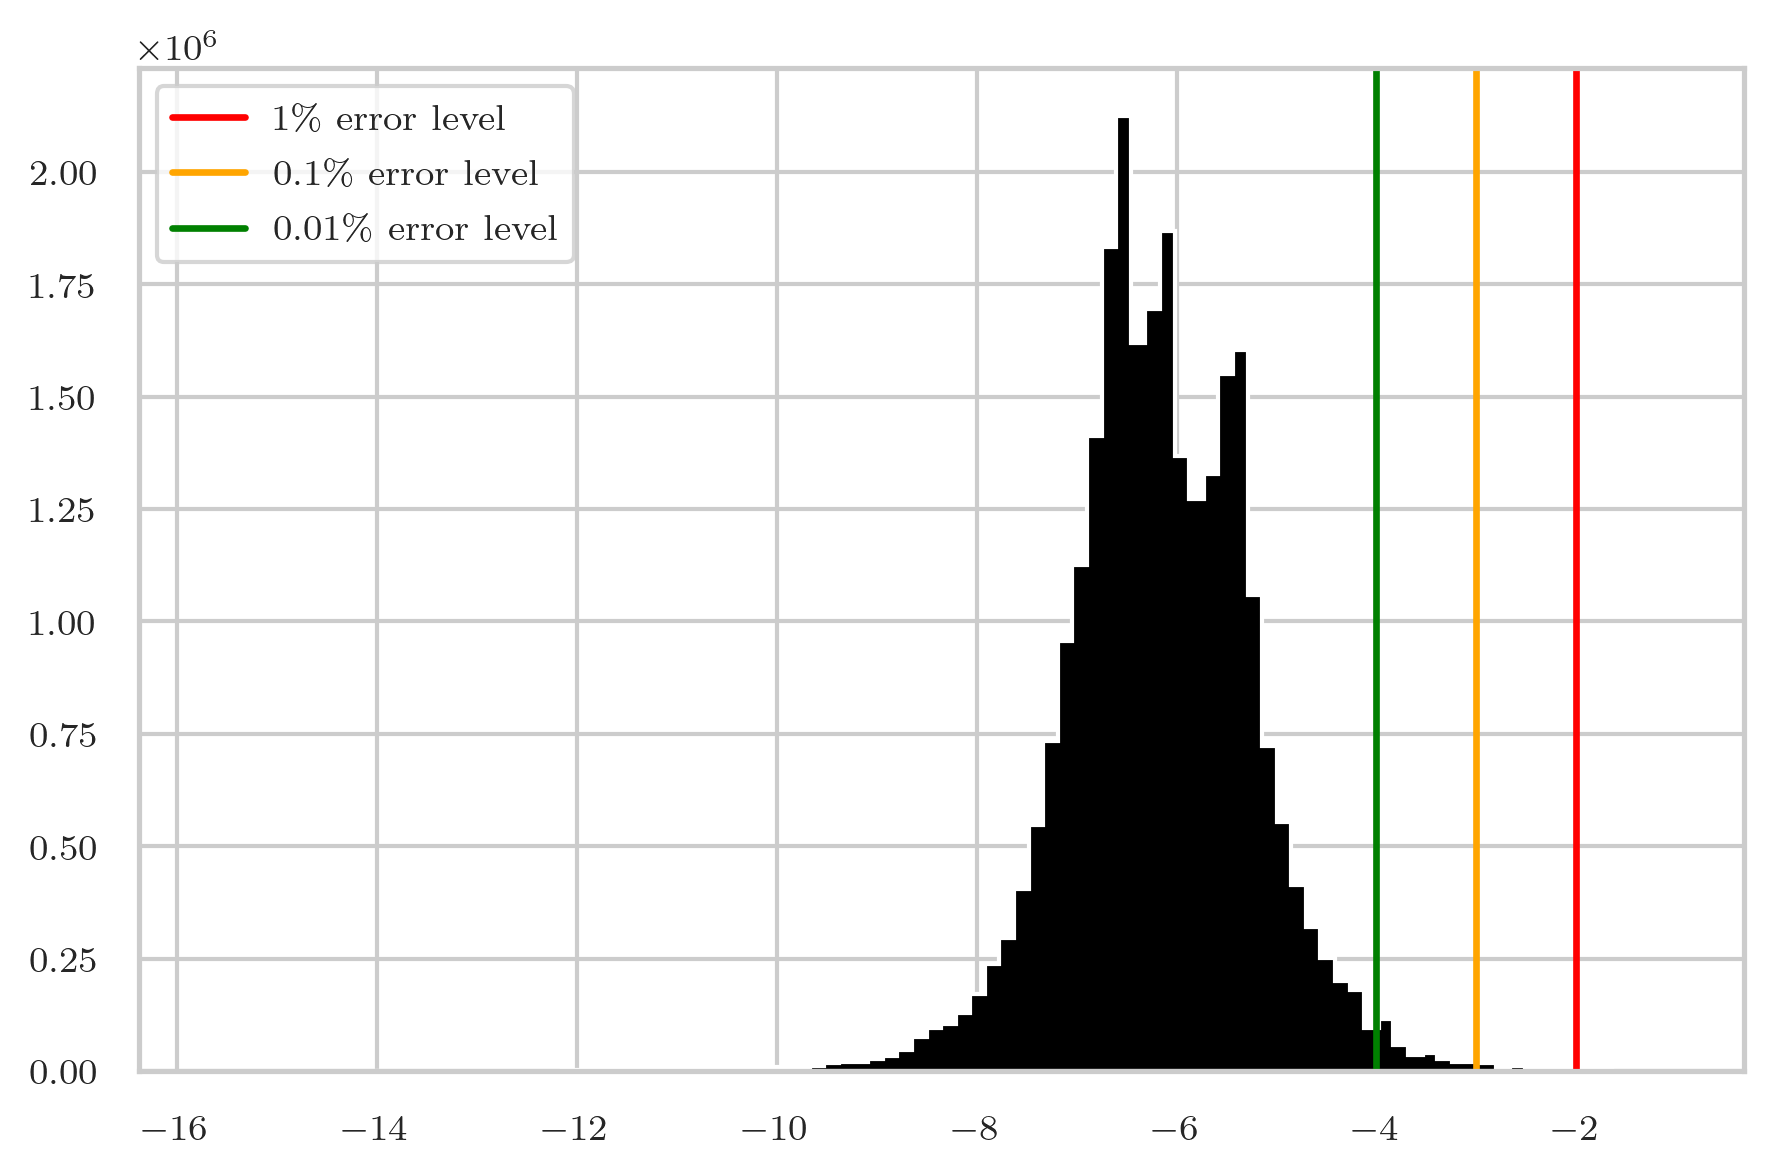

In [67]:
abs_errs = np.abs(errs_3d.flatten())
plt.hist(np.log10(abs_errs[abs_errs>0]), color='black', histtype='stepfilled', bins=100)
plt.axvline(-2, label='1\% error level', color='red')
plt.axvline(-3, label='0.1\% error level', color='orange')
plt.axvline(-4, label='0.01\% error level', color='green')
plt.legend(loc='best')
pass

Here you can see the emulator works quite well; there are some outlier large errors, but the vast majority are less than $1\%$ and even less than $0.01\%$ in fact, with some being so small they are below machine precision, which is why I had to include this code: `abs_errs[abs_errs>0]` to avoid log returning `-inf`.

So the determining factor of how well the emulator performs is mostly in how many parameters you have, not how many dimensions the function is.